In [1]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

d:\DATA\a.asri\doc-classifier


### Import des modules et fonctions

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow as tf

### Définition des classes et des fonctions (à mettre dans src ultérieurement)

In [7]:
# Fonction pour obtenir des images aléatoires
def get_random_images_from_folder(folder_path, extensions=['.tiff', '.jpg', '.jpeg']):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in extensions):
                image_paths.append(os.path.join(root, file))
    if len(image_paths) < 3:
        raise ValueError("Not enough images found in the specified folder.")
    return random.sample(image_paths, 4)

# Classe pour extraire les activations PyTorch
class ExtractActiv:
    def __init__(self, model, target):
        self.gradients = [] 
        self.model = model
        self.target = target

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        out = []
        self.gradients = []
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.target:
                x.register_hook(self.save_gradient) 
                out += [x]
        return out, x

class ModelOutputs:
    def __init__(self, model, feature_module, target):
        self.model = model
        self.feature = feature_module
        self.feature_extractor = ExtractActiv(self.feature, target)

    def get_gradients(self):
        return self.feature_extractor.gradients
    
    def __call__(self, inpu):
        activations = []
        for name, layer in self.model._modules.items():
            if layer == self.feature:
                activations, inpu = self.feature_extractor(inpu)
            elif "avgpool" in name.lower():
                inpu = layer(inpu)
                inpu = inpu.view(inpu.size(0), -1)
            else:
                inpu = layer(inpu)
        return activations, inpu

class GradCamTorch:
    def __init__(self, model, feature_layer=None, target_layer=2, use_cuda=False):
        self.model = model
        self.model.eval() 
        self.convlayer = feature_layer
        self.workflow = ModelOutputs(self.model, self.convlayer, target_layer)  
        self.use_cuda = use_cuda

    def forward(self, image):
        return self.model(image)

    def __call__(self, input_img, target_category=None):
        if self.use_cuda:
            input_img = input_img.cuda()

        features, output = self.workflow(input_img)
        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy())
            
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.use_cuda:
            one_hot = one_hot.cuda()
        
        one_hot = torch.sum(one_hot * output)
        self.convlayer.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)
        grads_val = self.workflow.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:][::-1])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Grad-CAM pour Keras
def grad_cam_keras(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    
    grads = tape.gradient(loss, conv_outputs)[0]
    output = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(output.shape[0:2], dtype=np.float32)
    
    for index, w in enumerate(weights):
        cam += w * output[:, :, index]
    
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    return cam

def preprocess_image(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    preprocessing = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    return preprocessing(img.copy()).unsqueeze(0)

def preprocess_image_keras(img):
    img = cv2.resize(img, (224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

def show_cam_on_image(img, mask):
    img = cv2.resize(img, (mask.shape[1], mask.shape[0]))  # Resize img to match mask dimensions
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    img = np.float32(img)
    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def eval_image_keras(model, path, layer_name):
    img = cv2.imread(path, 1)
    img = np.float32(img) / 255
    img = img[:, :, ::-1]
    input_img = preprocess_image_keras(img)

    cam = grad_cam_keras(model, input_img, layer_name)
    cam_img = show_cam_on_image(img, cam)
    return input_img, cam, cam_img, img

def eval_image_torch(model, gradcam, path, target_category=None):
    img = cv2.imread(path, 1)
    img = np.float32(img) / 255
    img = img[:, :, ::-1]
    input_img = preprocess_image(img)

    grayscale_cam = gradcam(input_img, target_category)
    cam = show_cam_on_image(img, grayscale_cam)
    return input_img, grayscale_cam, cam, img

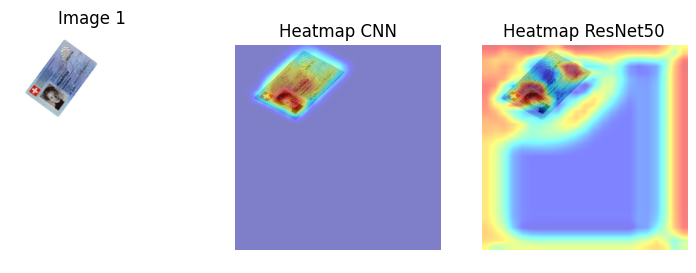

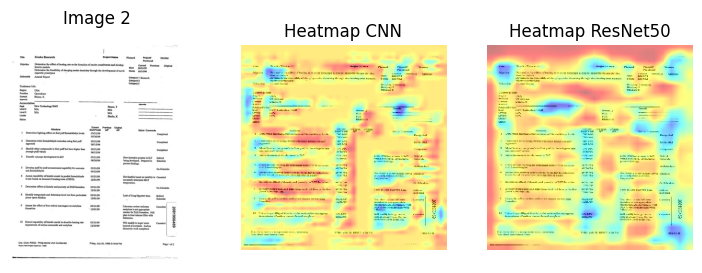

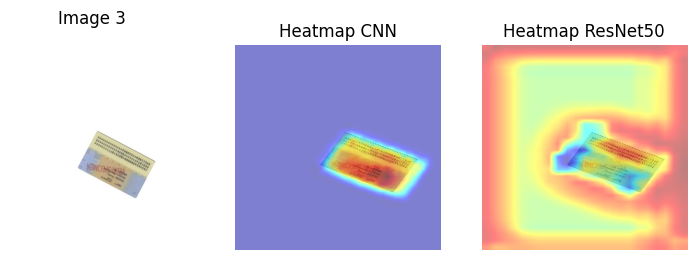

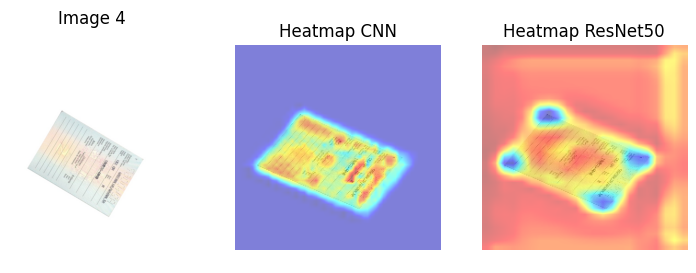

In [6]:
# Charger les modèles Keras
cnn_model = load_model('models/CNN_ckpt_best_acc.keras')
resnet50_keras_model = load_model('models/ResNet50_ckpt_best_acc.keras')

# Charger le modèle ResNet50 de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50_torch_model = models.resnet50(pretrained=True)
resnet50_torch_model.to(device)

# Spécifier la couche de caractéristique pour PyTorch
grad_cam_torch = GradCamTorch(resnet50_torch_model, feature_layer=resnet50_torch_model.layer4, target_layer=['2'], use_cuda=False)

# Obtenir des images aléatoires
image_paths = get_random_images_from_folder('data/raw')

# Evaluer les images
for i, image_path in enumerate(image_paths):
    # Pour le modèle CNN (Keras)
    input_img_cnn, grayscale_cam_cnn, cam_cnn, img_cnn = eval_image_keras(cnn_model, image_path, layer_name='conv2d_2')
    
    # Pour le modèle ResNet50 (PyTorch)
    input_img_resnet, grayscale_cam_resnet, cam_resnet, img_resnet = eval_image_torch(resnet50_torch_model, grad_cam_torch, image_path, target_category=None)
    
    # Assurer que toutes les images ont la même taille pour affichage
    target_size = (224, 224)
    img_cnn_resized = cv2.resize(img_cnn, target_size)
    cam_cnn_resized = cv2.resize(cam_cnn, target_size)
    cam_resnet_resized = cv2.resize(cam_resnet, target_size)

    # Afficher les résultats
    plt.figure(figsize=(9, 3))
    
    # Image originale
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f'Image {i + 1}')
    plt.axis('off')
    
    # Heatmap CNN
    plt.subplot(1, 3, 2)
    plt.imshow(cam_cnn_resized)
    plt.title('Heatmap CNN')
    plt.axis('off')
    
    # Heatmap ResNet50
    plt.subplot(1, 3, 3)
    plt.imshow(cam_resnet_resized)
    plt.title('Heatmap ResNet50')
    plt.axis('off')
    
    plt.show()
